## Data exploration of non-place enriched ER input data

Utrecht University, Applied Data Science, Master thesis

By Sander Engelberts (1422138)

May-June 2022

This file explores the non-place enriched personal record cards and passport requests data that was used as input for the entity resolution algorithm. Hence, this entails only a subset of the cleaned records for which candidates and a place entity retrieved from LOD sources exist.

In [67]:
# Import required packages
import os # for paths to files in operating system
import pandas as pd # for dataframes and operations on it
import datetime # for representing dates in a standardised format
from tqdm import tqdm # for displaying progress of operations
import numpy as np # for mathematical operations and missing values (np.nan)
import matplotlib.pyplot as plt # for plotting
import missingno as msno # for visualising missingness patterns in data
import re # for regular expressions on strings

tqdm.pandas() # display progress of pandas operations such as apply (use progress_apply instead)

### Exploring CBG personal record cards

This is the subset of personal record cards of which the recorded part of the meta data is checked via VeleHanden.nl and hence fully corresponds to the information recorded on its respective document. This data got exported on 10th of May 2022 and may at a later moment get extended with the newer checked personal record cards. The data explored in this file is a subset used for entity resolution after full data cleaning and place enrichment (although this one wasn't enriched with it, just only records remained that have an enriched variant), and dropping of records that didn't have any candidates (same for passport requests hereafter).

In [68]:
# Path to folder where I stored the data, so adjust to own storage location
data_path = "E:\CBG" 

# Path to personal record cards data
person_card_path = os.path.join(data_path, "blocked_persoonskaarten.csv")

In [69]:
# Load personal record cards data into a dataframe
df_person_card = pd.read_csv(person_card_path, sep=",", header=0, index_col=None)

In [70]:
# Inspect personal record cards data
df_person_card.columns

Index(['id', 'Achternaam', 'Voornaam', 'Geboortedatum', 'Geboorteplaats',
       'Geboorteprovincie', 'Geboorteland', 'Blocking_key',
       'Blocking_key_first_name', 'Blocking_key_last_name'],
      dtype='object')

These translation/description of these columns is:
* 'id' : unique identifier of personal record card at CBG
* 'Achternaam' : last name of key person
* 'Voornaam' : first name of key person
* 'Geboortedatum' : birth date in YYYY-MM-DD format
* 'Geboorteplaats' : birth place name
* 'Geboorteprovincie' : birth province name
* 'Geboorteland' : birth country name
* 'Blocking_key' : blocking key for the first and last names, which is used to determine candidates to compare a record to during entity resolution
* 'Blocking_key_first_name' : blocking key for the first name(s)
* 'Blocking_key_last_name' : blocking key for the last name

In [ ]:
# Inspect personal record cards data
# Output cleared due to privacy-sensitive data
df_person_card.head()

In [73]:
print("The input personal record cards data contains ", len(df_person_card), " records")

The original person card data contains  73538  records


In [74]:
# Check how many missing values are remained in the columns
df_person_card.isna().sum()

id                             0
Achternaam                     0
Voornaam                      39
Geboortedatum                  1
Geboorteplaats                 0
Geboorteprovincie          26274
Geboorteland               23593
Blocking_key                   0
Blocking_key_first_name        0
Blocking_key_last_name         0
dtype: int64

In [75]:
# Check types of columns
df_person_card.dtypes

id                         object
Achternaam                 object
Voornaam                   object
Geboortedatum              object
Geboorteplaats             object
Geboorteprovincie          object
Geboorteland               object
Blocking_key               object
Blocking_key_first_name    object
Blocking_key_last_name     object
dtype: object

In [76]:
# Check number of unique values in each column
df_person_card.nunique()

id                         73538
Achternaam                  7168
Voornaam                    9846
Geboortedatum              26944
Geboorteplaats              1668
Geboorteprovincie             11
Geboorteland                  37
Blocking_key               12600
Blocking_key_first_name     3042
Blocking_key_last_name      4515
dtype: int64

In [77]:
def visualise_missingness(df):
    '''
    Visualise missingness patterns in data with multiple diagrams from msno library
    
    Parameters
    ----------
    df : Pandas dataframe
        Dataframe for which to visualise missingness patterns
    '''
    # Visualise matrix where white lines indicate missing values in each attribute
    msno.matrix(df)
    plt.show()
    
    # Visualise heatmap to show correlations between attributes:
    # positive correlation with blue (the darker the shade of blue, the more the correlation),
    # and negative correlation with red
    msno.heatmap(df)
    plt.show()
    
    # Visualise bar plot to show the values that are proportional to the non-missing data in 
    # the dataset, along with the number of non-missing values per attribute
    msno.bar(df)
    plt.show()

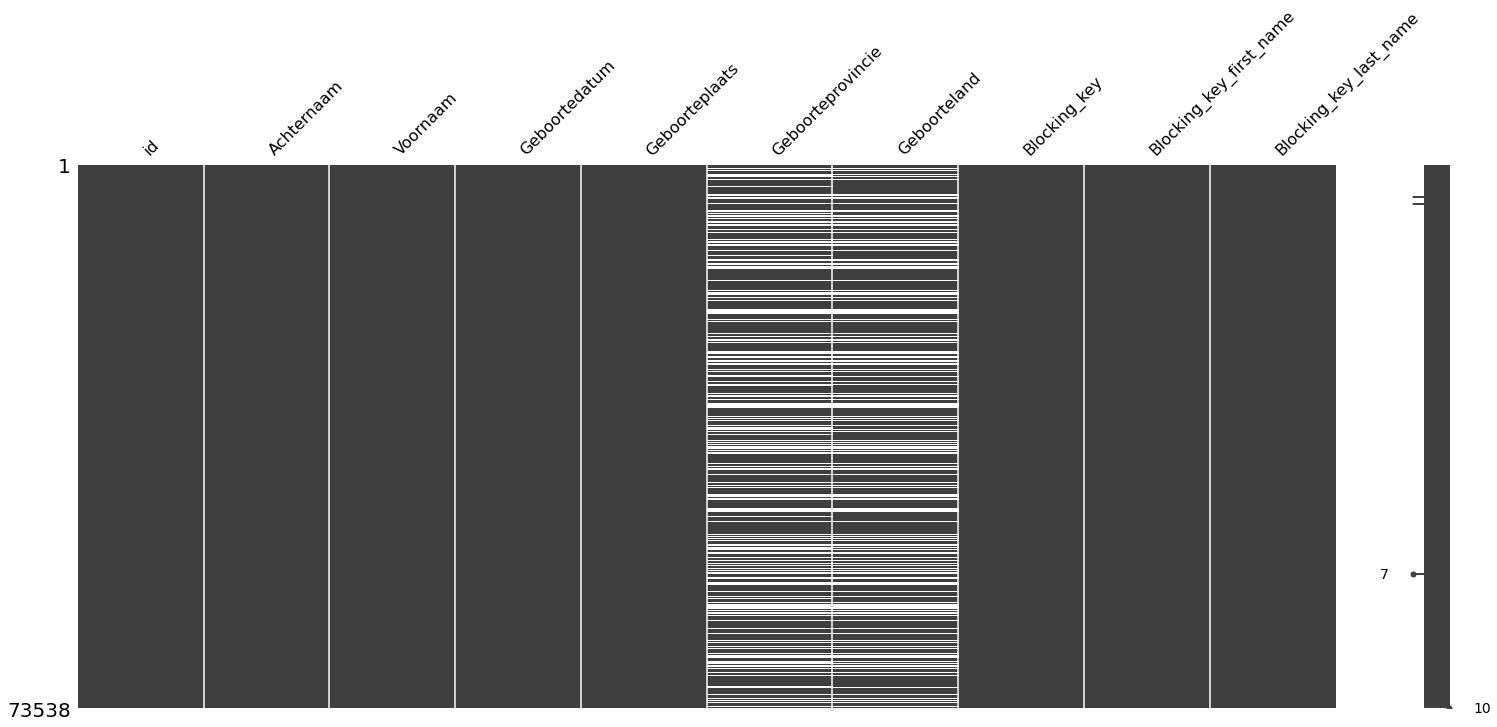

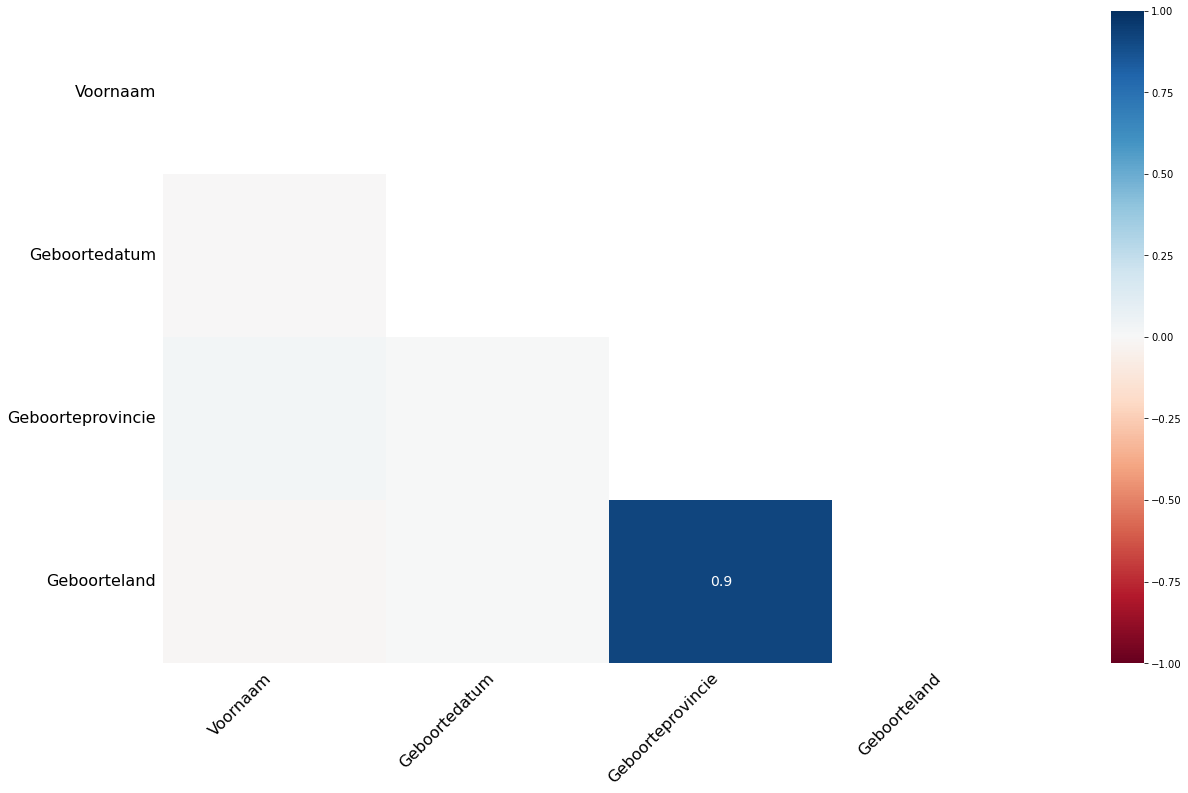

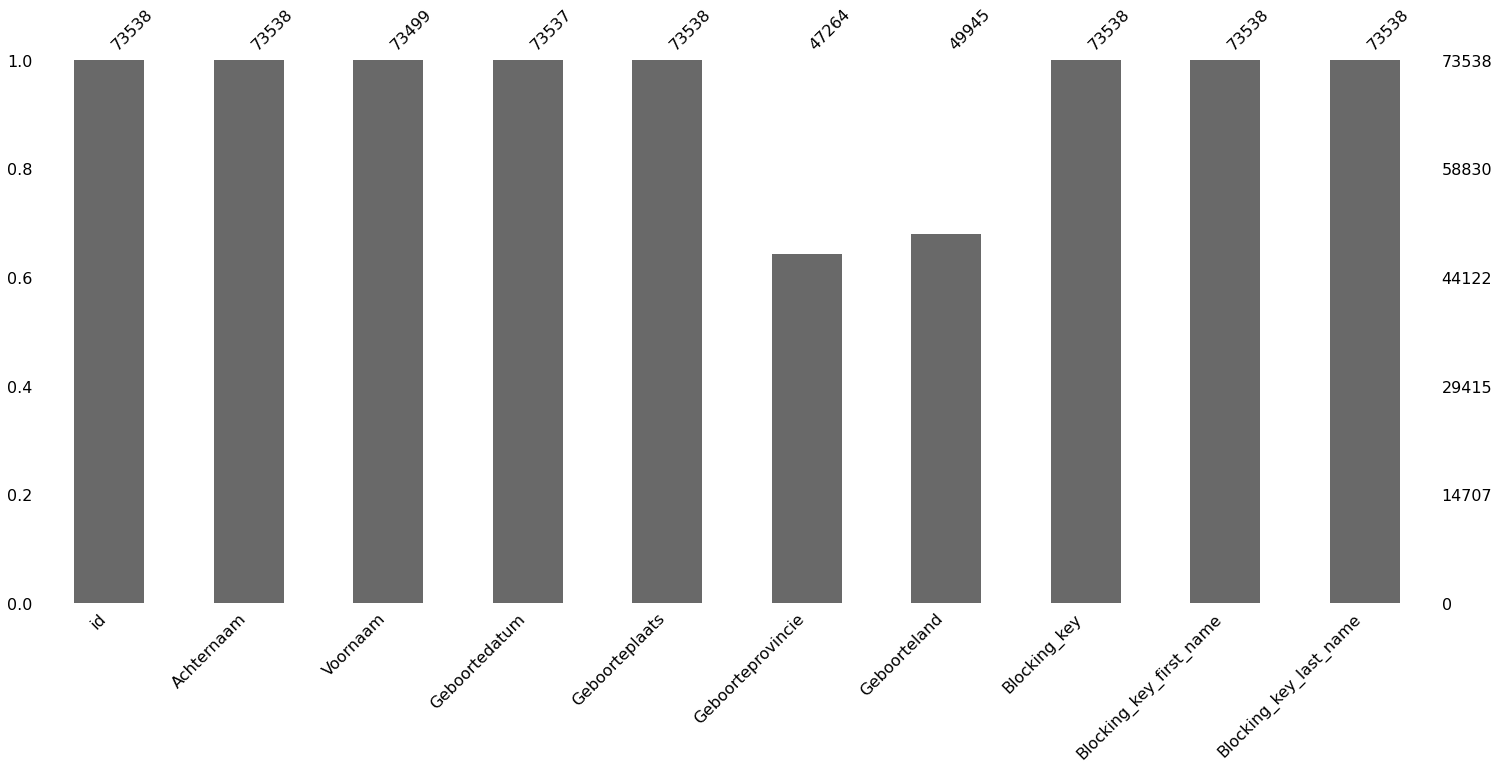

In [78]:
# Visualise final missingness patterns
visualise_missingness(df=df_person_card)

In [80]:
# Check for most common first names (as full combination of multiple names)
# Note that missing values are not included
df_person_card.Voornaam.value_counts(normalize=True).head(20)

Jan              0.096178
Cornelis         0.051511
Johannes         0.047293
Hendrik          0.044735
Willem           0.041824
Pieter           0.031511
Gerrit           0.021619
Johanna          0.020857
Maria            0.019470
Jacob            0.016381
Arie             0.015959
Cornelia         0.014490
Jacobus          0.013184
Adrianus         0.012490
Dirk             0.011606
Wilhelmina       0.009048
Hendrikus        0.008299
Klaas            0.007905
Johanna Maria    0.007293
Petrus           0.006803
Name: Voornaam, dtype: float64

In [81]:
# Check for most common last names
# Note that missing values are not included
df_person_card.Achternaam.value_counts(normalize=True).head(20)

Bakker          0.063763
van den Berg    0.055142
van Dijk        0.032296
Dekker          0.021839
Visser          0.018548
Brouwer         0.017338
van Dongen      0.011667
Smit            0.010960
Dijkstra        0.010362
de Groot        0.009682
de Boer         0.008594
de Vries        0.008145
de Bruin        0.007765
van Beek        0.007588
de Graaf        0.007438
de Bruijn       0.007248
Blom            0.006038
van der Veen    0.006010
Bos             0.005779
van Deursen     0.005548
Name: Achternaam, dtype: float64

In [82]:
# Check for most common birth dates
# Note that missing values are not included
df_person_card.Geboortedatum.value_counts(normalize=True).head(20)

1897-10-16    0.000218
1899-08-04    0.000190
1902-01-26    0.000177
1902-05-04    0.000177
1904-09-24    0.000177
1902-03-07    0.000177
1902-05-19    0.000177
1900-05-21    0.000177
1896-02-22    0.000177
1905-08-19    0.000177
1902-04-03    0.000163
1900-01-20    0.000163
1896-05-06    0.000163
1892-02-21    0.000163
1898-08-23    0.000163
1900-04-01    0.000163
1893-03-04    0.000163
1901-03-18    0.000163
1901-08-11    0.000163
1901-02-02    0.000163
Name: Geboortedatum, dtype: float64

In [83]:
def date_distribution(df_dates):
    '''
    Determine temporal distribution of dates recorded in documents 
    by checking its statistics and displaying the distribution of 
    counts of records per year in a line plot
    
    df_dates : Pandas series
        Series containing dates as datetime.date objects
    '''
    # Make sure that dates is datetime object (partly missing values are strings, others NaN)
    # If can't do it, then will replace the date for NaT object
    dates = pd.to_datetime(df_dates, errors='coerce')
    # Remove NaT values 
    dates = dates.dropna(how='any')
    
    # Group dates by year, and determine counts of records per year 
    dates_count = dates.groupby(dates.dt.year).count()

    # Determine date years statistics
    min_date = dates_count.keys().min()
    max_date = dates_count.keys().max()
    mean_date = np.mean(dates_count.keys())
    median_date = np.median(dates_count.keys())
    print("Date statistics are:")
    print("Minimum: ", min_date)
    print("Maximum: ", max_date)
    print("Average: ", mean_date)
    print("Median: ", median_date)

    # Determine the x-axis labels (the last item is exclusive so add one year)
    x_years = np.arange(min_date, max_date+1, step=10) 
    
    # Plot date distribution in line plot 
    fig,ax = plt.subplots()
    dates_count.plot(x_compat=True, ax=ax, ylabel='Number of records', xlabel='Birth year',
                    xticks = x_years)
    plt.xticks(rotation=90) # Rotate x-labels
    plt.show()

Date statistics are:
Minimum:  1834
Maximum:  1987
Average:  1912.46
Median:  1912.5


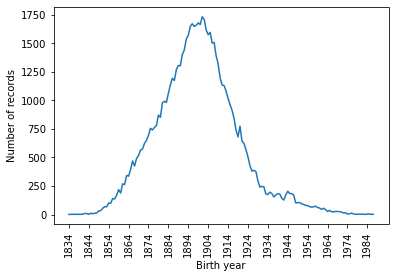

In [84]:
# Display statistics and distribution of birth dates 
# Note that (partly) missing values are not included
date_distribution(df_dates=df_person_card.Geboortedatum)

In [85]:
# Check for most common birth places
# Note that missing values are not included
df_person_card.Geboorteplaats.value_counts(normalize=True).head(20)

Amsterdam           0.058650
Rotterdam           0.057548
's-Gravenhage       0.034078
Utrecht             0.022288
Leiden              0.012511
Haarlem             0.010648
Tilburg             0.009968
Dordrecht           0.008948
Arnhem              0.008431
Groningen           0.007153
Nijmegen            0.007085
Delft               0.007071
Helder              0.006378
Ede                 0.006242
's-Hertogenbosch    0.006133
Vlaardingen         0.006119
Schiedam            0.006078
Zaandam             0.005820
Zwolle              0.005698
Apeldoorn           0.005575
Name: Geboorteplaats, dtype: float64

In [86]:
# Check for frequency of Dutch birth provinces 
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_freq = df_person_card['Geboorteprovincie'].value_counts(normalize=True)
province_freq

Zuid-Holland     0.210139
Noord-Brabant    0.179524
Noord-Holland    0.152061
Gelderland       0.120663
Friesland        0.077183
Utrecht          0.068847
Overijssel       0.056660
Groningen        0.040030
Drenthe          0.035566
Zeeland          0.030404
Limburg          0.028923
Name: Geboorteprovincie, dtype: float64

In [87]:
def province_pie_chart(province_frequency):
    """
    Visualise a circle diagram that shows the frequency distribution of province names
    
    Parameters
    ----------
    province_frequency : Pandas series
        Series containing counts of each unique province value in the data
    """
    # Get the 10 default colours and add two to get 12 colours for each Dutch province
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    colors = colors + ['salmon', 'coral']

    # Create circle diagram 
    province_frequency.plot.pie(ylabel='', autopct='%1.1f%%', normalize=True, colors=colors)

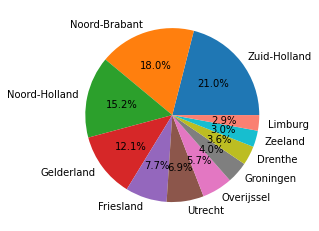

In [88]:
# Create circle diagram of Dutch province distribution
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_pie_chart(province_frequency=province_freq)

In [89]:
# Check for most common birth countries
# Note that missing values are not included
# Note that the Netherlands is partially mentioned more because that was filled in when a 
# Dutch province name indicator was found in the recorded place name, which was not inferred 
# for provinces of other countries
df_person_card['Geboorteland'].value_counts(normalize=True).head(20)                                           

Nederland                                   0.927340
Indonesië                                   0.026609
Nederland, Oostenrijk                       0.012053
Nederland, Denemarken                       0.011893
Duitsland                                   0.005046
Nederland, Nederlandse Antillen             0.004765
Nederland, Ijsland                          0.004685
Oostenrijk, Nederland                       0.002383
België                                      0.001682
Oostenrijk                                  0.000561
Oostenrijk, Nederland, Oostenrijk           0.000461
Denemarken                                  0.000461
Suriname                                    0.000420
Ijsland                                     0.000280
Denemarken, Nederland                       0.000260
Nederland, Verenigde Arabische Republiek    0.000260
Nederlandse Antillen                        0.000140
Zuid-Afrika                                 0.000120
Australië                                   0.

In [90]:
# Check for most common blocking key
df_person_card['Blocking_key'].value_counts(normalize=True).head(20)

jan_an_J500_bak_er_B260    0.006908
jan_an_J500_van_jk_V532    0.005317
jan_an_J500_van_rg_V535    0.004515
pie_er_P360_bak_er_B260    0.004460
cor_is_C654_bak_er_B260    0.004175
joh_es_J520_van_rg_V535    0.004148
jan_an_J500_dek_er_D260    0.004039
jan_an_J500_bro_er_B660    0.003440
cor_is_C654_van_rg_V535    0.003223
joh_es_J520_van_en_V536    0.003196
hen_ik_H536_bak_er_B260    0.003196
wil_em_W450_van_jk_V532    0.003168
jan_an_J500_dij_ra_D236    0.003019
hen_ik_H536_van_rg_V535    0.002992
cor_is_C654_van_jk_V532    0.002924
ger_it_G630_van_jk_V532    0.002842
jac_ob_J210_bak_er_B260    0.002747
jan_an_J500_van_en_V536    0.002720
pet_us_P362_van_en_V536    0.002652
wil_em_W450_bak_er_B260    0.002652
Name: Blocking_key, dtype: float64

### Exploring CBG passport requests

This is the subset of passport requests of which the recorded part of the meta data is digitized by people who do not understand Dutch nor Indonesian and hence may not fully corresponds to the information recorded on its respective document. This data got exported on 10th of May 2022. The data explored in this file is a subset used for entity resolution after full data cleaning and place enrichment (although this one wasn't enriched with it, just only records remained that have an enriched variant), and dropping of records that didn't have any candidates.

In [91]:
# Path to passport requests data
passport_path = os.path.join(data_path, "blocked_Indische_paspoorten.csv")

In [92]:
# Load passport requests data into a dataframe
df_passport = pd.read_csv(passport_path, sep=",", header=0, index_col=None)

In [93]:
# Inspect passport request data
df_passport.columns

Index(['id', 'Voornaam', 'Geboortedatum', 'Geboorteplaats', 'Geboorteland',
       'Geboorteprovincie', 'Achternaam', 'Blocking_key',
       'Blocking_key_first_name', 'Blocking_key_last_name'],
      dtype='object')

These translation/description of these columns is:
* 'id' : unique identifier of passport request at CBG
* 'Achternaam' : last name of key person
* 'Voornaam' : first name of key person
* 'Geboortedatum' : birth date in YYYY-MM-DD format
* 'Geboorteplaats' : birth place name
* 'Geboorteprovincie' : birth province name
* 'Geboorteland' : birth country name
* 'Blocking_key' : blocking key for the first and last names, which is used to determine candidates to compare a record to during entity resolution
* 'Blocking_key_first_name' : blocking key for the first name(s)
* 'Blocking_key_last_name' : blocking key for the last name

In [ ]:
# Inspect passport requests data
# Output cleared due to privacy-sensitive data
df_passport.head()

In [ ]:
# Inspect all columns of one record
# Output cleared due to privacy-sensitive data
df_passport.iloc[0]

In [97]:
print("The input passport request data contains ", len(df_passport), " records")

The original passport request data contains  13730  records


In [98]:
# Check how many missing values are remained in the columns
df_passport.isna().sum()

id                             0
Voornaam                      43
Geboortedatum                  5
Geboorteplaats                 0
Geboorteland               10786
Geboorteprovincie          13503
Achternaam                     0
Blocking_key                   0
Blocking_key_first_name        0
Blocking_key_last_name         0
dtype: int64

In [99]:
# Check types of columns
df_passport.dtypes

id                          int64
Voornaam                   object
Geboortedatum              object
Geboorteplaats             object
Geboorteland               object
Geboorteprovincie          object
Achternaam                 object
Blocking_key               object
Blocking_key_first_name    object
Blocking_key_last_name     object
dtype: object

In [100]:
# Check number of unique values in each column
df_passport.nunique()

id                         13730
Voornaam                    5997
Geboortedatum               9609
Geboorteplaats              1410
Geboorteland                  12
Geboorteprovincie             11
Achternaam                  6034
Blocking_key               12600
Blocking_key_first_name     3042
Blocking_key_last_name      4515
dtype: int64

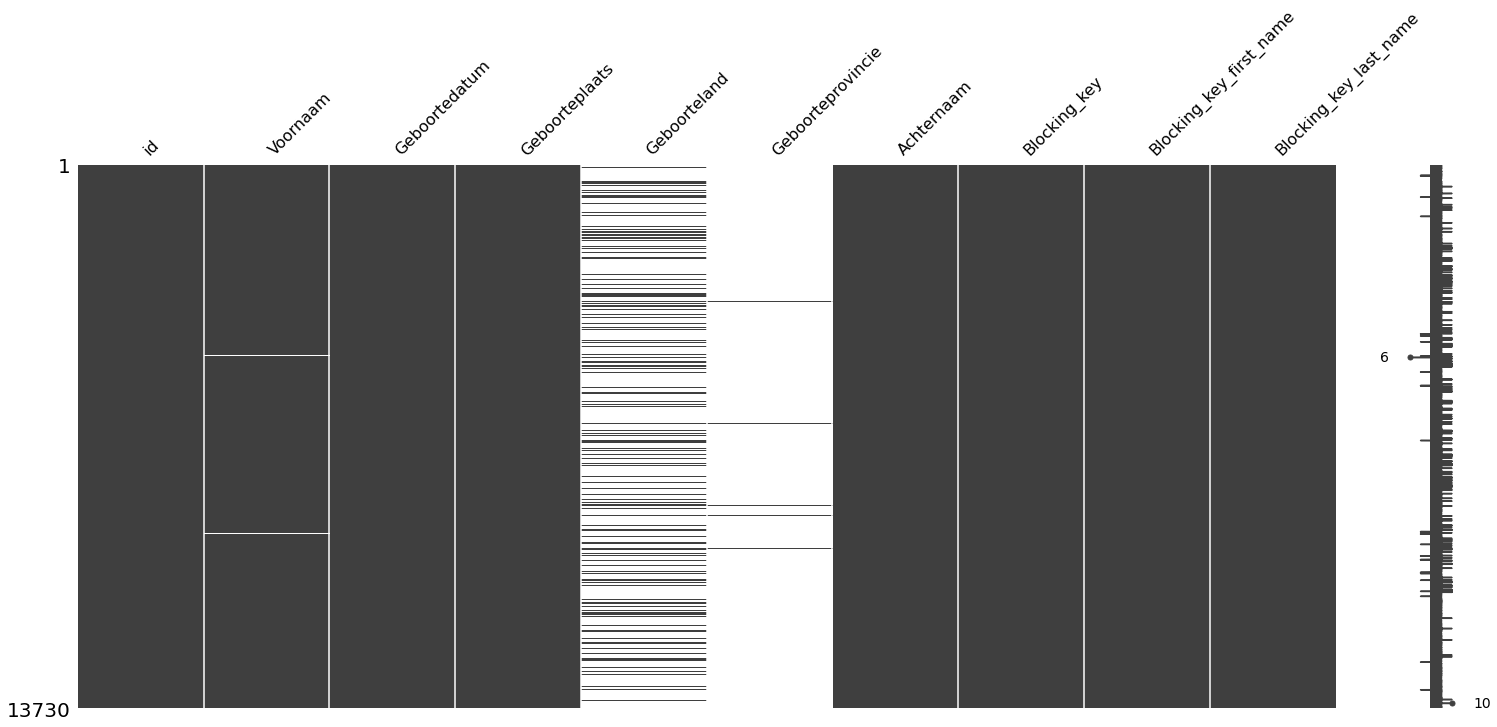

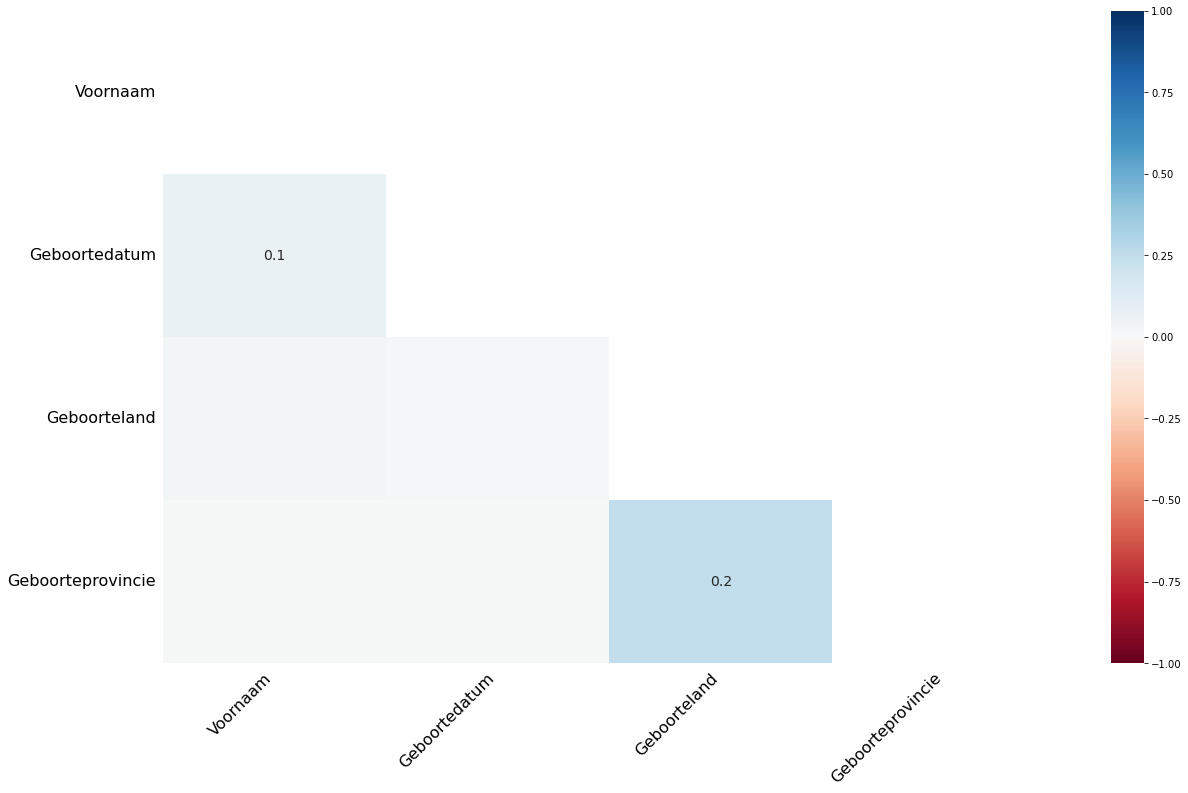

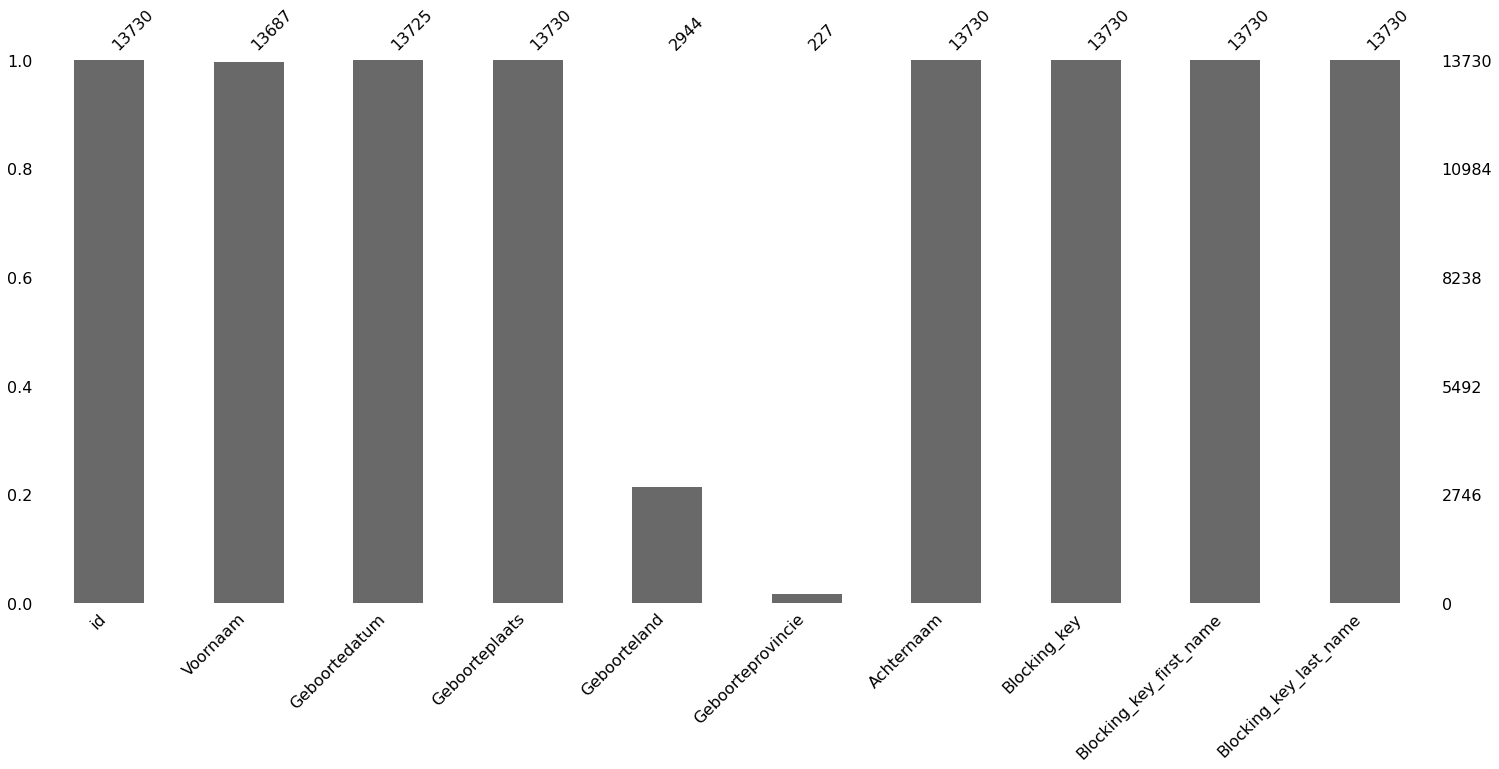

In [101]:
# Visualise final missingness patterns
visualise_missingness(df=df_passport)

In [103]:
# Check which value options there are for 'Geboorteland' (birth country) and 
# their frequency balance. Note that missing values are not included
df_passport.Geboorteland.value_counts(normalize=True)

Nederland                        0.722826
Denemarken                       0.212296
Indonesië                        0.034986
Oostenrijk                       0.011889
Nederlandse Antillen             0.008492
België                           0.003736
Ijsland                          0.002717
Duitsland                        0.001019
Verenigde Arabische Republiek    0.000679
Nederland, Oostenrijk            0.000679
Ierland                          0.000340
Nederland, Ijsland               0.000340
Name: Geboorteland, dtype: float64

In [104]:
# Check for most common first names (as full combination of multiple names)
# Note that missing values are not included
df_passport.Voornaam.value_counts(normalize=True).head(20)

Jan              0.039088
Willem           0.023307
Johannes         0.021261
Hendrik          0.020823
Cornelis         0.020603
Pieter           0.016950
Jacob            0.010009
Gerrit           0.010009
Johanna          0.008841
Dirk             0.008402
Maria            0.007818
Arie             0.007306
Johan            0.006868
Jacobus          0.006576
Cornelia         0.005845
Adrianus         0.005772
Wilhelmina       0.005041
Anna             0.004968
Johanna Maria    0.004530
Elisabeth        0.004457
Name: Voornaam, dtype: float64

In [105]:
# Check for most common last names
# Note that missing values are not included
df_passport.Achternaam.value_counts(normalize=True).head(20)

Bakker            0.011435
van den Berg      0.009468
Visser            0.008667
Smit              0.007720
de Groot          0.007210
van Dijk          0.006846
Brouwer           0.005535
Dekker            0.004734
de Vries          0.004370
de Boer           0.003496
Vos               0.003496
van der Linden    0.003423
de Graaf          0.003350
Schouten          0.002840
Vermeulen         0.002840
Dijkstra          0.002768
Smits             0.002695
de Wit            0.002695
de Bruin          0.002622
van Wijk          0.002549
Name: Achternaam, dtype: float64

In [106]:
# Check for most common birth dates
# Note that missing values are not included
df_passport.Geboortedatum.value_counts(normalize=True).head(20)

1907-05-15    0.000510
1922-01-16    0.000437
1919-11-11    0.000437
1926-02-01    0.000437
1908-04-29    0.000364
1912-11-14    0.000364
1921-11-21    0.000364
1915-08-23    0.000364
1908-05-02    0.000364
1924-07-25    0.000364
1918-11-15    0.000364
1929-08-17    0.000364
1915-12-14    0.000364
1926-11-20    0.000364
1916-04-21    0.000364
1919-12-13    0.000364
1915-03-12    0.000364
1904-02-02    0.000364
1908-09-05    0.000364
1921-02-04    0.000364
Name: Geboortedatum, dtype: float64

Date statistics are:
Minimum:  1824
Maximum:  1958
Average:  1907.6521739130435
Median:  1908.5


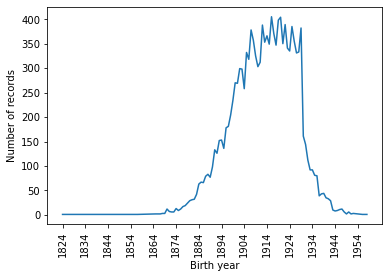

In [107]:
# Display statistics and distribution of birth dates 
# Note that (partly) missing values are not included
date_distribution(df_dates=df_passport.Geboortedatum)

In [108]:
# Check for most common birth places
# Note that missing values are not included
# Note that some places have multiple spelling variations like Soerabaja
df_passport.Geboorteplaats.value_counts(normalize=True).head(20)

Amsterdam        0.101092
Rotterdam        0.079898
Semarang         0.040932
Haag             0.031974
's-Gravenhage    0.031901
Batavia          0.026074
Utrecht          0.026001
Malang           0.019228
Haarlem          0.016387
Magelang         0.014421
Padang           0.013693
Bandung          0.012891
Helder           0.012163
Leiden           0.011071
Arnhem           0.010415
Dordrecht        0.009177
Salatiga         0.008230
Delft            0.007939
Nijmegen         0.007793
Medan            0.007720
Name: Geboorteplaats, dtype: float64

In [109]:
# Check for most common Dutch birth provinces
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_freq_passport = df_passport.Geboorteprovincie.value_counts(normalize=True).head(20)
province_freq_passport  

Noord-Brabant    0.185022
Gelderland       0.136564
Noord-Holland    0.136564
Zuid-Holland     0.118943
Overijssel       0.105727
Limburg          0.101322
Friesland        0.074890
Drenthe          0.044053
Groningen        0.035242
Utrecht          0.035242
Zeeland          0.026432
Name: Geboorteprovincie, dtype: float64

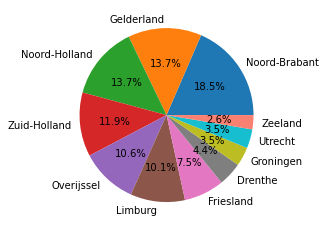

In [110]:
# Create circle diagram of Dutch province distribution
# Note that missing values (incl. provinces outside of the Netherlands) are not included
province_pie_chart(province_frequency=province_freq_passport)

In [111]:
# Check for most common blocking key
df_passport['Blocking_key'].value_counts(normalize=True).head(20)

jan_an_J500_bak_er_B260    0.000874
wil_em_W450_van_en_V536    0.000728
pie_er_P360_van_en_V536    0.000655
cor_is_C654_de_ot_D263     0.000510
cor_is_C654_van_en_V536    0.000510
jac_us_J212_van_en_V536    0.000510
joh_us_J521_van_en_V536    0.000437
jan_an_J500_van_en_V545    0.000437
ger_us_G663_van_en_V536    0.000437
cor_is_C654_van_en_V545    0.000437
jan_an_J500_van_en_V536    0.000437
jan_an_J500_van_rg_V535    0.000437
jac_ob_J210_bak_er_B260    0.000437
joh_es_J520_van_en_V523    0.000437
pie_er_P360_bak_er_B260    0.000364
dir_rk_D620_van_en_V536    0.000364
jan_an_J500_ten_ve_T510    0.000364
joh_es_J520_smi_it_S530    0.000364
jan_an_J500_de_af_D261     0.000364
wil_em_W450_van_rg_V535    0.000364
Name: Blocking_key, dtype: float64